In [161]:
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
import statsmodels.api as sm


In [162]:
df = pd.read_csv('/content/country_vaccinations.csv')

In [163]:
df.dropna(subset=['daily_vaccinations'], inplace=True)

In [164]:
ro = df.loc[df['country'] =='Romania']

In [165]:
ro.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
63654,Romania,ROU,2020-12-28,2066.0,2066.0,NaN,1101.0,1101.0,0.01,0.01,NaN,58.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Government of Romania via datelazi.ro,https://datelazi.ro/
63655,Romania,ROU,2020-12-29,2778.0,2778.0,NaN,712.0,906.0,0.01,0.01,NaN,47.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Government of Romania via datelazi.ro,https://datelazi.ro/
63656,Romania,ROU,2020-12-30,5666.0,5666.0,NaN,2888.0,1567.0,0.03,0.03,NaN,82.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Government of Romania via datelazi.ro,https://datelazi.ro/
63657,Romania,ROU,2020-12-31,10289.0,10289.0,NaN,4623.0,2331.0,0.05,0.05,NaN,122.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Government of Romania via datelazi.ro,https://datelazi.ro/
63658,Romania,ROU,2021-01-01,11656.0,11656.0,NaN,1367.0,2138.0,0.06,0.06,NaN,112.0,"Johnson&Johnson, Moderna, Oxford/AstraZeneca, ...",Government of Romania via datelazi.ro,https://datelazi.ro/


We are now going to explore how the daily vaccination process is going on in Romania.

In [166]:

fig = px.line(ro, x='date', y="daily_vaccinations", title='Daily vaccinations in Romania')
fig.show()

By what we can see in this plot, it seems like there was an ascending trend that starts in the winter and tapers off during the summer. There might be several explanations for this occuring:


1.   During the summertime, in Romania all Covid restrictions were relaxed, which might have make people less likely to get the vaccine
2.   Between two consecutive doses there is a maximum interval of four weeks, which might mean that the bulk of people who got vaccinated in May had to wait until September to get their second dose



In [168]:
ro['date'] = pd.to_datetime(ro['date'])
ro.set_index('date', inplace=True)
ts = ro['daily_vaccinations']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



The first thing when dealing with time series is checking whether the data is stationary or not. 

In [169]:

result = adfuller(ts.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.154057
p-value: 0.223340


After performing the Augmented Dickey Fuller test, we can see that the p-value is much greater than the significance level (0.05), which means that our data is not stationary. Further analysis is required.

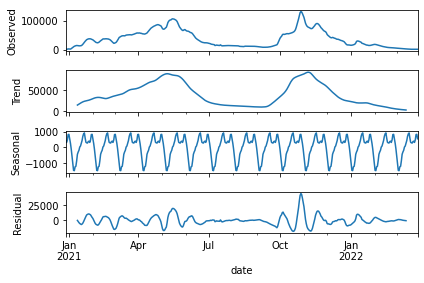

In [170]:


ts = ts.fillna(method='bfill').fillna(method='ffill')
decomposition = sm.tsa.seasonal_decompose(ts, freq=30)
fig = decomposition.plot()

There is no apparent trend, however there seems to be some seasonality, so we are going to perform differencing in order to remove it

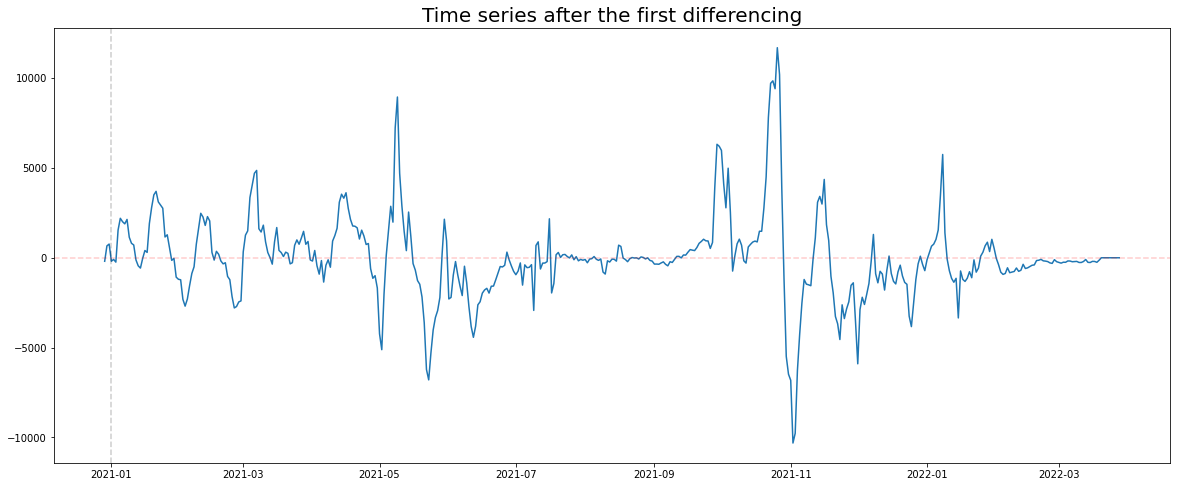

In [171]:
first_diff = ts.diff()[1:]

plt.figure(figsize=(20,8))
plt.plot(first_diff)
plt.title('Time series after the first differencing', fontsize=20)
for year in range(2021, 2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

By just looking at our plot, the time series does seem to be stationary: its mean is around 0 and there are no clear patterns.

We should now perform the ADF test again.


In [172]:
result = adfuller(first_diff.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.990784
p-value: 0.001460


THis proved our intuition right, so we can start to investigate which model fits the best, by looking at the autocorrelation and partial autocorrelation plots.

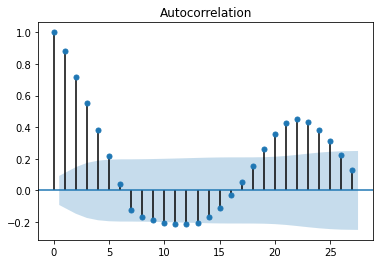

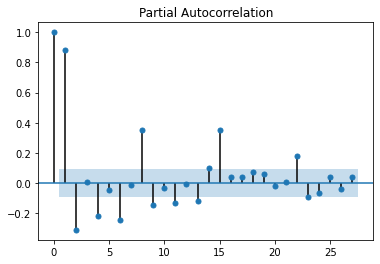

In [173]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_plot = plot_acf(first_diff)
pacf_plot = plot_pacf(first_diff)

The autocorrelation plot shows that our data comes from a very strong autoregressive model with strong positive autocorrelations. 


In [174]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(ts, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARIMA Model Results                               
Dep. Variable:     D.daily_vaccinations   No. Observations:                  455
Model:                   ARIMA(1, 1, 2)   Log Likelihood               -3808.678
Method:                         css-mle   S.D. of innovations           1043.019
Date:                  Sun, 15 May 2022   AIC                           7627.357
Time:                          19:07:23   BIC                           7647.958
Sample:                      12-29-2020   HQIC                          7635.473
                           - 03-28-2022                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.2352    349.433      0.001      0.999    -684.640     685.111
ar.L1.D.daily_vaccinations     0.8137      0.034     24.122      0.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



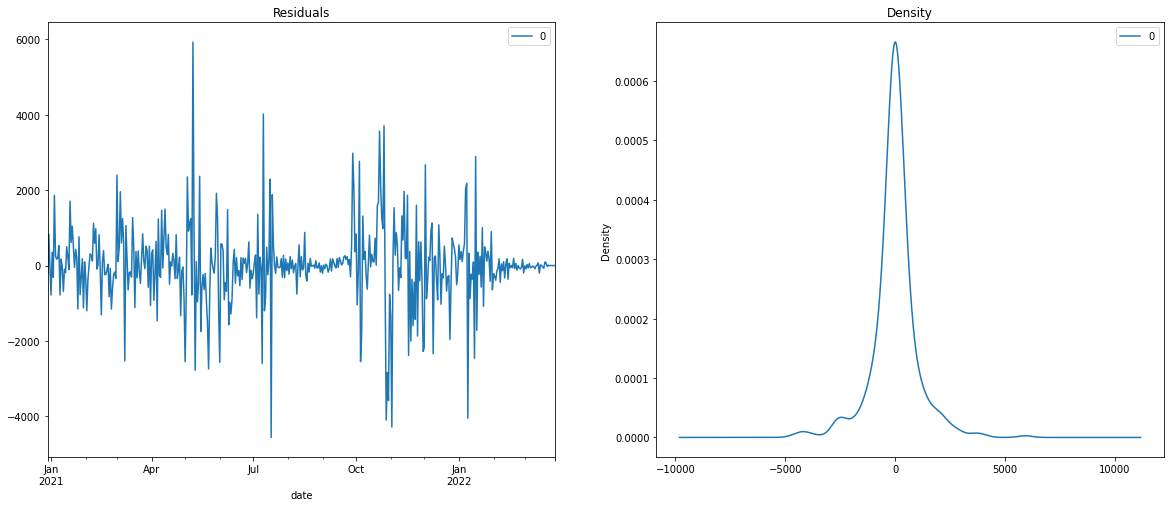

In [175]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(20,8))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual plot seems fine, with near zero mean and uniform variance.
We should now plot how our model performs when predicting.

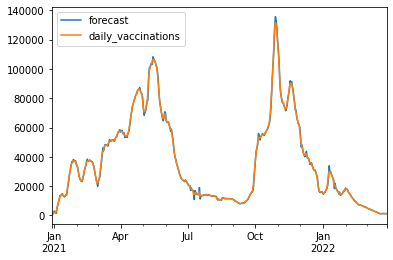

In [176]:


model_fit.plot_predict(dynamic=False)
plt.show()

From what we have seen, our data is very dependent on past observations, meaning it is rather easy to make predictions.